In [1]:
import pickle
import math
import sys
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset
from skimage import draw
from skimage import io
from skimage import io, transform, measure
import pickle
import os
import matplotlib
from scipy.special import expit
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import numpy as np
import warnings
from sklearn import metrics
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
plt.rcParams["figure.figsize"] = (10,10)
warnings.filterwarnings("ignore")




mel_class_labels = ['TRBL', 'BDG', 'WLSA', 'ESA', 'GP', 'PV', 'PRL']
nev_class_labels = ['APC', 'MS', 'OPC']
char_class_labels = mel_class_labels+nev_class_labels


mappings = {
	'thick reticular or branched lines': 'TRBL',
	'dicke retikuläre oder verzweigte Linien': 'TRBL',

	'eccentrically located structureless area': 'ESA',
	'exzentrisch gelegenes, strukturloses Areal jeglicher Farbe, außer hautfarben, weiß und grau': 'ESA',

	'grey patterns': 'GP',
	'graue Muster': 'GP',

	'polymorphous vessels': 'PV',
	'polymorphe Gefäße': 'PV',

	'pseudopods or radial lines at the lesion margin that do not occupy the entire lesional circumference': 'PRL',
	'pseudopodien oder radiale Linien am Läsionsrand, die nicht den gesamten Läsionsumfang einnehmen': 'PRL',

	'black dots or globules in the periphery of the lesion': 'BDG',
	'schwarze Punkte oder Schollen in der Läsionsperipherie': 'BDG',

	'white lines or white structureless area': 'WLSA',
	'weiße Linien oder weißes strukturloses Areal': 'WLSA',

	'parallel lines on ridges (acral lesions only)': 'PLR',
	'parallele Linien auf den Leisten (nur akrale Läsionen)': 'PLR',

	'pigmentation extends beyond the area of the scar (only after excision)': 'PES',
	'pigmentierung überschreitet Narbenareal (nur nach Entfernung)': 'PES',

	'pigmentation invades the openings of hair follicles (facial lesions)': 'PIF',
	'pigmentierung überschreitet Follikelöffnung (Gesichtsläsionen)': 'PIF',

	'only one pattern and only one colour': 'OPC',
	'nur ein Muster und nur eine Farbe': 'OPC',

	'symmetrical combination of patterns and;or colours': 'SPC',
	'symmetrische Kombination von Mustern und;oder Farben': 'SPC',

	'monomorphic vascular pattern': 'MVP',
	'monomorphes Gefäßmuster': 'MVP',

	'pseudopods or radial lines at the lesional margin involving the entire lesional circumference': 'PRLC',
	'pseudopodien oder radiale Linien am Läsionsrand über den gesamten Läsionsumfang': 'PRLC',

	'parallel lines in the furrows (acral lesions only)': 'PLF',
	'parallele Linien in den Furchen (nur akrale Läsionen)': 'PLF',

	'pigmentation does not extend beyond the area of the scar (only after excision)': 'PDES',
	'pigmentierung überschreitet Narbe nicht (nur nach Entfernung)': 'PDES',

	'asymmetric combination of multiple patterns or colours in the absence of other melanoma criteria': 'APC',
	'asymmetrische Kombination mehrerer Muster und;oder Farben ohne weitere Melanomkriterien': 'APC',

	'melanoma simulator': 'MS',
	'melanomsimulator': 'MS',
    
	'please select at least one explanation': 'XX',
	'bitte wählen Sie mindestens eine Erklärung aus.': 'XX',
    'andere (bitte angeben)': 'XX'
}

def confidence_interval(data, size=10000, func=np.mean):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    np.random.seed(42)
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return np.percentile(bs_replicates, [2.5, 97.5])


class DiceScore(nn.Module):
    def __init__(self):
        super(DiceScore, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):
        
        num = targets.shape[0]
        inputs = inputs.reshape(num, -1)
        targets = targets.reshape(num, -1)
        
        inputs = np.clip(inputs, a_min=0, a_max=1)
        targets = np.clip(targets, a_min=0, a_max=1)

        intersection = (inputs * targets).sum(1)
        dice = (2. * intersection + smooth) / (inputs.sum(1) + targets.sum(1) + smooth)

        dice = dice.sum() / num

        return dice
    

def polygon2mask(polygon):
    """
    Create an image mask from polygon coordinates
    """
    vertex_row_coords, vertex_col_coords, shape = polygon[:, 1], polygon[:, 0], (450, 600)
    
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=float)
    mask[fill_row_coords, fill_col_coords] = 1.
    mask = transform.resize(mask, (224, 224))
    return mask


def process_annotations(y_annotations):
    masks = [polygon2mask(ann) for ann in y_annotations]
    mask = np.bitwise_or.reduce(masks)
    return mask


backbones = ["resnet18", "resnet34", "resnet50", "resnet101",
             "densenet121", "densenet161", "efficientnetb1", "efficientnetb3"]

/home/kti01/miniconda3/envs/artifact_detection/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
backbone = "efficientnetb3"

baseline_attributions_path = "/home/kti01/Documents/My Files/Projects/overlap_ablations/attributions/baseline/"
classifier_attributions_path = "/home/kti01/Documents/My Files/Projects/overlap_ablations/attributions/classifier/"


predictions_path = os.path.join(classifier_attributions_path, backbone)
phase1_path = "/home/kti01/Documents/My Files/Projects/Overlap/data/phase1"
phase3_path = "/home/kti01/Documents/My Files/Projects/Overlap/data/phase3"
phase2_path = "/home/kti01/Documents/My Files/Projects/Overlap/data/phase2"
metadata_phase1 = pd.read_pickle(os.path.join(phase1_path, "metadata_phase1.pkl"))
metadata_phase3 = pd.read_csv(os.path.join(phase3_path, "metadata_phase3.csv"))
metadata_phase3 = metadata_phase3[~metadata_phase3.issues.isin(['Insufficient Image Quality', 'unzureichende Bildqualität'])]

metadata_phase1['prediction'] = np.floor(metadata_phase1['prediction'])
metadata_phase3['prediction'] = np.floor(metadata_phase3['prediction'])

## Explanatory Classifier ROI Overlap

In [37]:
%%time

def threshold_attributions(attributions):
                
    attr_non_zero = attributions[attributions>0.]
    if len(attr_non_zero) == 0:
        perc = 0
    else:
        perc = (np.percentile(attr_non_zero, 0))
    attr = (attributions >= perc)
    return attr


def jaccard_score(img1, img2):
    img1 = img1.flatten()
    img2 = img2.flatten()
    img1 = img1 > 0
    img2 = img2 > 0
    return metrics.jaccard_score(img1, img2)


def correlation(img1, img2, smooth=1e-6, p=1):
    
    corr = stats.spearmanr(img1.flatten(), img2.flatten())[0]
    return corr


def dice_coef(y_true, y_pred, smooth=1e-6, p=1):
    y_true_f = y_true.flatten().clip(0, 1)
    y_pred_f = y_pred.flatten().clip(0, 1)
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f**p) + np.sum(y_pred_f**p) + smooth)



def get_percentile_attr(attr):
    attr_non_zero = attr[attr>0.]
    if len(attr_non_zero) == 0:
        perc = 0
    else:
        perc = (np.percentile(attr_non_zero, 80))
    attr = (attr >= perc).astype(int)
    return attr

dice = DiceScore()
overlap_func = dice_coef
overlaps = []
participants = []
masks = []
predictions = []
exp_rois = {}
for idx, row in metadata_phase1.iterrows():
    
    try:
    
        if row.participant in ['e21', 'e41', 'e70', 'e87', 'g71']:
                continue

        if row['prediction'] in [0, 1]:

            mask = str(int(row['mask']))

            mask = str(row['image_id'])

            # Get AI pred list
            ai_pred = pd.read_csv(os.path.join(predictions_path, mask, 'predictions_'+mask+'.csv'))
            ai_pred = list(ai_pred[ai_pred['confidence'] != 'low']['label'])
            ai_pred = [mappings[pred] for pred in ai_pred]
            # Get AI ROI dict
            ai_attributions = pd.read_pickle(os.path.join(predictions_path, mask, mask+'.pkl'))
            ai_roi = {}
            for pred in ai_pred:
                index = char_class_labels.index(pred)
                roi = ai_attributions[index]
                perc = (np.percentile(roi, 80))
                roi = (roi >= perc).astype(int)
                ai_roi[pred] = roi 

            # Get doc pred list
            doc_pred = row[char_class_labels]
            doc_pred = list(doc_pred[doc_pred == 1].index)

            # Get doc ROI dict
            doc_roi = {}
            for pred in doc_pred:
                doc_roi[pred] = polygon2mask(row[pred+'_annotation'][0]) 

            # Calculate overlap on the ROIs of each feature separately
            pred_intersection = list(set(ai_pred).intersection(doc_pred))

            """Agreement on prediction AND on at least one explanation"""
            #if row['prediction'] != row['AI_prediction']:
            #    continue
            #if len(pred_intersection) == 0:
            #    continue

            doc_roi = np.logical_or.reduce([roi for pred, roi in doc_roi.items()]).astype(int)
            """
            AI ROI calculated by merging ROIs of all predictions.
            AI ROI is top 80th percentile
            """
            ai_roi = np.logical_or.reduce([roi for pred, roi in ai_roi.items()]).astype(int)
            #if ai_roi.sum() == 0:
            #    continue
            overlap = overlap_func(ai_roi, doc_roi)

            overlaps.append(overlap)
            participants.append(row['participant'])
            masks.append(row['mask'])
            predictions.append(row['prediction'])

            num = row['participant'] + '.' + str(row['image_id'])
            exp_rois[num] = (doc_roi, ai_roi)
    except:
        pass
overlap_exp = pd.DataFrame({'participant': participants, 'mask': masks, 'overlap': overlaps, 'prediction_phase1': predictions})
overlap_exp = pd.merge(overlap_exp, metadata_phase3,  how='left', left_on=['participant','mask'], right_on =['participant','mask']).dropna()

CPU times: user 34.2 s, sys: 664 ms, total: 34.9 s
Wall time: 35.1 s


## Baseline 

In [38]:
%%time

with open(os.path.join(baseline_attributions_path, "attributions_dict_"+backbone+".pkl"), 'rb') as handle:
    attributions_dict = pickle.load(handle)

overlaps = []
participants = []
masks = []
predictions = []
baseline_rois = {'ai_roi': [], 'doc_roi': [], 'overlap': []}
for idx, row in metadata_phase1.iterrows():
    
    if row.participant in ['e21', 'e41', 'e70', 'e87', 'g71']:
            continue
    
    if row['prediction'] in [0, 0.5, 1]:
    
        mask = str(int(row['mask']))
        
        output, attributions = attributions_dict[row.image_id]
        """
        AI ROI is top 80th percentile
        """
        AI_pred = 1 if output >= 0.5 else 0
        ai_roi = attributions[0]
        perc = (np.percentile(ai_roi, 80))
        ai_roi = (ai_roi >= perc).astype(int)
        
        """Agreement on prediction"""
        #if row.prediction != AI_pred:
        #    continue
                
        # Get doc pred list
        doc_pred = row[char_class_labels]
        doc_pred = list(doc_pred[doc_pred == 1].index)
        if len(doc_pred) == 0:
            continue
        # Get doc ROI dict
        doc_roi = {}
        for pred in doc_pred:
            doc_roi[pred] = polygon2mask(row[pred+'_annotation'][0]) 

        doc_roi = np.logical_or.reduce([roi for roi in doc_roi.values()]).astype(int)
        
        overlap = overlap_func(ai_roi, doc_roi)

        overlaps.append(overlap)
        participants.append(row['participant'])
        masks.append(row['mask'])
        predictions.append(row['prediction'])
        
        num = row['participant'] + '.' + str(row['image_id'])
        baseline_rois[num] = (doc_roi, ai_roi)


overlap_baseline = pd.DataFrame({'participant': participants, 'mask': masks, 'overlap': overlaps, 'prediction_phase1': predictions})
overlap_baseline = pd.merge(overlap_baseline, metadata_phase3,  how='left', left_on=['participant','mask'], right_on =['participant','mask']).dropna()

CPU times: user 30 s, sys: 27.9 ms, total: 30 s
Wall time: 30 s


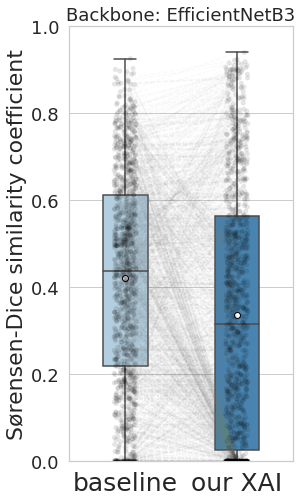

In [39]:
# If phase 3 prediction is different from phase 1, drop the instance since it cant be used for overlap calculation
x = overlap_baseline[overlap_baseline.prediction_phase1 == overlap_baseline.prediction]
y = overlap_exp[overlap_exp.prediction_phase1 == overlap_exp.prediction]

df = pd.merge(overlap_baseline, overlap_exp, how='inner', left_on=['participant','mask'], right_on=['participant','mask'])
df.rename({'overlap_x': 'baseline', 'overlap_y': 'our XAI'}, axis=1, inplace=True)

plt.figure(figsize=(4,8))
palette = sns.color_palette(['grey'], len(df))
sns.boxplot(data=df[['baseline', 'our XAI']], width=0.4, palette='Blues', 
            showfliers=False, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", 
                                                         "markeredgecolor":"black", "markersize":"6"})
sns.lineplot(data=df[['baseline', 'our XAI']].T, palette=palette, alpha=0.04)
plt.legend('', frameon=False)
sns.stripplot(data=df[['baseline', 'our XAI']], color='black', alpha=0.1)
plt.yticks(size=18)
plt.xticks(size=25)
plt.ylim(0, 1)
plt.ylabel('Sørensen-Dice similarity coefficient', size=22)
plt.title(f'Backbone: EfficientNetB3', fontdict={"fontsize": 18})
plt.savefig('/home/kti01/Documents/My Files/Projects/overlap_ablations/attributions/plots/'+backbone+'.png', dpi=500, bbox_inches='tight')

In [68]:
print(df.baseline.mean())
print(confidence_interval(df.baseline))
print()
print(df['our XAI'].mean())
print(confidence_interval(df['our XAI']))
print()
print(stats.ttest_rel(df.baseline, df['our XAI']))
print(df.shape)

0.397867099779725
[0.3844915  0.41143415]

0.4787661582631489
[0.46256999 0.49501043]

Ttest_relResult(statistic=-12.77352661240643, pvalue=5.60615596119017e-35)
(1120, 24)


In [69]:
df[['participant', 'mask', 'baseline', 'our XAI']].to_csv('../Source Data/Extended_Data_Fig3g.csv', index=None)

In [79]:
import pandas as pd
import numpy as np

# Create a dictionary with sample data
data = {'category': ['A', 'A', 'B', 'B'], 
        'value': [np.random.normal(10, 2, 100), 
                  np.random.normal(12, 2, 100),
                  np.random.normal(8, 2, 100), 
                  np.random.normal(6, 2, 100)]}

# Convert the dictionary to a pandas dataframe
df = pd.DataFrame(data)

# Explode the 'value' column to create a long-form dataframe
df = df.explode('value')

# Convert the 'value' column to a float
df['value'] = df['value'].astype(float)

# Print the first few rows of the dataframe
print(df.head())


  category      value
0        A   6.624335
0        A   9.720940
0        A  10.332407
0        A  11.115657
0        A  10.241980


(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

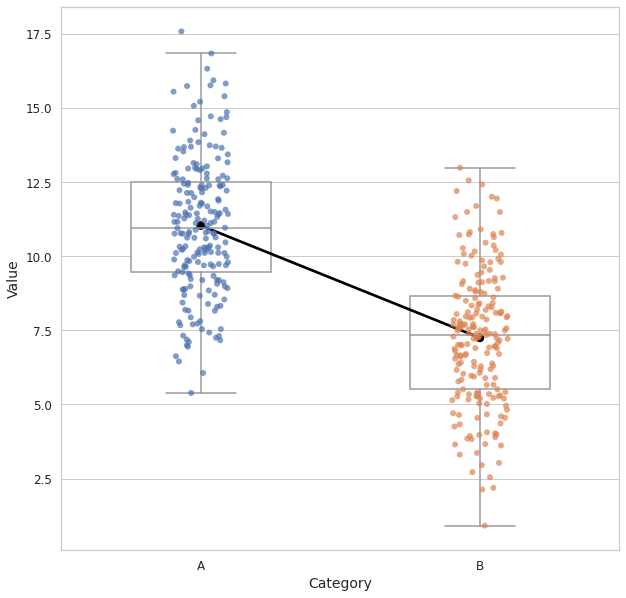

In [87]:
import seaborn as sns

# Assuming your pandas dataframe is named 'df'
sns.boxplot(x='category', y='value', data=df, 
            color='white', saturation=1, width=0.5, 
            fliersize=0, linewidth=1.5, whis=1.5)

sns.stripplot(x='category', y='value', data=df, 
              jitter=True, edgecolor='gray', size=6, alpha=0.7)

sns.pointplot(x='category', y='value', data=df, 
              color='black', marker='o', markersize=8, 
              mec='black', ci=None)

plt.xlabel('Category', fontsize=14)
plt.ylabel('Value', fontsize=14)

# Increase the font size of the x-axis and y-axis ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [95]:
df = df[['participant', 'baseline', 'our XAI']]
df

,participant,baseline,our XAI
0,g80,0.749315,0.819470
1,g80,0.422996,0.107602
2,g80,0.739010,0.793585
3,g80,0.537044,0.680879
4,g80,0.458506,0.112904
...,...,...,...
1115,e81,0.143614,0.830764
1116,e81,0.256277,0.256232
1117,e81,0.562957,0.167990
1118,e81,0.430719,0.500917


In [96]:
pd.melt(df, id_vars=['participant'], var_name='classifier', value_name='value')

,participant,classifier,value
0,g80,baseline,0.749315
1,g80,baseline,0.422996
2,g80,baseline,0.739010
3,g80,baseline,0.537044
4,g80,baseline,0.458506
...,...,...,...
2235,e81,our XAI,0.830764
2236,e81,our XAI,0.256232
2237,e81,our XAI,0.167990
2238,e81,our XAI,0.500917
